# Online Retail – K-Means: Raw Numeric (RFM) vs Apriori Features
**Notebook hoàn chỉnh**: EDA → Clean → (A) Raw numeric (RFM) → Scale → K-Means (Elbow+Silhouette) → PCA visualize → Export
và (B) Apriori features → Scale → K-Means (Elbow+Silhouette) → PCA visualize → Export

> Dataset “Online Retail” thường có các cột: `InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country`.


## 0) Cài thư viện (chạy 1 lần nếu thiếu)

In [35]:
# Nếu máy bạn chưa có, chạy cell này
#pip install pandas numpy matplotlib seaborn mlxtend scikit-learn openpyxl


## 1) Đọc dữ liệu (tự động dò file trong /)

In [17]:

import os, glob, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings("ignore")

DATA_DIR = ""

patterns = [
    "*HeartDisease*.xlsx", "*HeartDisease*.csv",
]
candidates = []
for p in patterns:
    candidates += glob.glob(os.path.join(DATA_DIR, p))

print("Found candidates:", candidates)

if not candidates:
    any_files = glob.glob(os.path.join(DATA_DIR, "*.xlsx")) + glob.glob(os.path.join(DATA_DIR, "*.csv"))
    print("Fallback any csv/xlsx:", any_files[:10])
    if not any_files:
        raise FileNotFoundError("Không tìm thấy file .csv/.xlsx trong /mnt/data. Hãy upload dữ liệu Online Retail.")
    FILE = any_files[0]
else:
    FILE = candidates[0]

print("Using:", FILE)

def read_data(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    for enc in ["utf-8", "utf-8-sig", "ISO-8859-1", "latin1", "cp1252"]:
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            continue
    return pd.read_csv(path, low_memory=False)

df = read_data(FILE)
print("Shape:", df.shape)
df.head()


Found candidates: ['HeartDiseaseTrain-Test.csv', 'HeartDisease_Apriori_Clusters.csv', 'HeartDisease_Clusters_Apriori.csv', 'HeartDisease_Clusters_Raw.csv']
Using: HeartDiseaseTrain-Test.csv
Shape: (1025, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


## 2) EDA nhanh

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1025 non-null   int64  
 1   sex                            1025 non-null   object 
 2   chest_pain_type                1025 non-null   object 
 3   resting_blood_pressure         1025 non-null   int64  
 4   cholestoral                    1025 non-null   int64  
 5   fasting_blood_sugar            1025 non-null   object 
 6   rest_ecg                       1025 non-null   object 
 7   Max_heart_rate                 1025 non-null   int64  
 8   exercise_induced_angina        1025 non-null   object 
 9   oldpeak                        1025 non-null   float64
 10  slope                          1025 non-null   object 
 11  vessels_colored_by_flourosopy  1025 non-null   object 
 12  thalassemia                    1025 non-null   o

In [19]:
df.isna().sum().sort_values(ascending=False).head(20)

age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure           0
cholestoral                      0
fasting_blood_sugar              0
rest_ecg                         0
Max_heart_rate                   0
exercise_induced_angina          0
oldpeak                          0
slope                            0
vessels_colored_by_flourosopy    0
thalassemia                      0
target                           0
dtype: int64

In [20]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
df[num_cols].describe().T


Numeric columns: ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak', 'target']


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
resting_blood_pressure,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
cholestoral,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
Max_heart_rate,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2
target,1025.0,0.513171,0.500070,0.0,0.0,1.0,1.0,1.0


### 2.1 Histogram Quantity / UnitPrice (nếu có)

In [21]:

for col in ["Quantity", "UnitPrice"]:
    if col in df.columns:
        plt.figure(figsize=(7,4))
        plt.hist(df[col].dropna(), bins=60)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


## 3) Làm sạch dữ liệu (chuẩn Online Retail)

In [22]:
import pandas as pd
import numpy as np

# Đọc file dữ liệu mới
df = pd.read_csv('HeartDiseaseTrain-Test.csv')

# 1. Kiểm tra và loại bỏ dữ liệu trống
df.dropna(inplace=True)

# 2. Xử lý dữ liệu nhiễu (Ví dụ: huyết áp hoặc cholesterol không thể bằng 0)
df = df[(df['resting_blood_pressure'] > 0) & (df['cholestoral'] > 0)]

# 3. Chuyển đổi các cột phân loại (Object) thành kiểu Category để dễ xử lý
categorical_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 
                    'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()

print("Dữ liệu đã làm sạch. Kích thước:", df.shape)
df.head()

Dữ liệu đã làm sạch. Kích thước: (1025, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


## 4) Helper: K-Means + Elbow + Silhouette + PCA visualize

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def run_clustering_helper(X_scaled, max_k=10, title_prefix=""):
    """
    Hàm helper thực hiện: 
    1. Elbow method (biểu đồ WCSS)
    2. Silhouette analysis (biểu đồ Silhouette)
    3. Tìm K tốt nhất & Hiển thị PCA Visualize
    """
    wcss = []
    sil_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        wcss.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X_scaled, labels))

    # --- Vẽ biểu đồ Elbow và Silhouette ---
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.set_xlabel('Số lượng cụm (k)')
    ax1.set_ylabel('WCSS (Elbow)', color='blue')
    ax1.plot(k_range, wcss, marker='o', color='blue', label='WCSS')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color='red')
    ax2.plot(k_range, sil_scores, marker='s', color='red', label='Silhouette')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{title_prefix} - Elbow & Silhouette Analysis')
    plt.show()

    # Chọn k có Silhouette cao nhất để Visualize
    best_k = k_range[np.argmax(sil_scores)]
    print(f"==> K tối ưu dựa trên Silhouette cho {title_prefix} là: {best_k}")
    
    # Final Model & PCA
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels_final = kmeans_final.fit_predict(X_scaled)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_final, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'{title_prefix} - PCA Visualization (K={best_k})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    return labels_final, best_k

## 5) Cách A – Raw numeric (RFM) → Scale → K-Means → PCA → Export

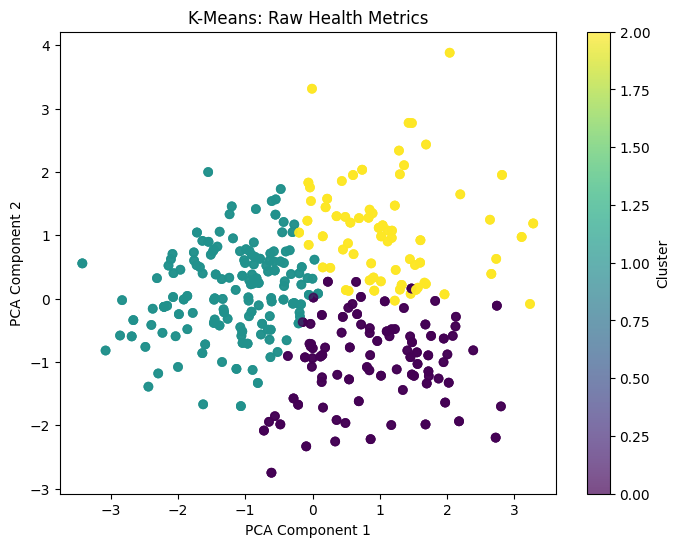

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters(X, labels, title):
    # Giảm chiều dữ liệu về 2D để vẽ
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

# Sau đó bạn có thể gọi hàm như bình thường
plot_clusters(X_raw_scaled, df['Cluster_Raw'], "K-Means: Raw Health Metrics")

### 5.1 Tóm tắt cụm (RAW RFM)

In [26]:
summary_raw = df.groupby('Cluster_Raw')[raw_cols].mean()
print("Tóm tắt đặc trưng trung bình theo từng cụm (Raw):")
display(summary_raw)

Tóm tắt đặc trưng trung bình theo từng cụm (Raw):


,age,resting_blood_pressure,cholestoral,Max_heart_rate,oldpeak
Cluster_Raw,,,,,
0,59.070064,126.391720,229.707006,127.458599,1.905732
1,48.457806,125.434599,233.761603,163.917722,0.399578
2,60.244726,150.881857,292.063291,148.198312,1.310127


### 5.2 Export CSV (RAW RFM clusters)

In [31]:
df.to_csv('HeartDisease_Clusters_Raw.csv', index=False)

## 6) Cách B – Apriori Features → Scale → K-Means → PCA → Export

In [ ]:
from mlxtend.frequent_patterns import apriori

# --- Bước 1: Tạo Features từ Apriori (Binary Matrix) ---
# Giả sử chúng ta dùng các đặc điểm bệnh lý làm "item"
categorical_cols = ['chest_pain_type', 'rest_ecg', 'thalassemia']
df_bin = pd.get_dummies(df[categorical_cols])

In [41]:
freq_items = apriori(df_bin, min_support=0.05, use_colnames=True)

In [42]:
X_apriori = df_bin.values

In [43]:
scaler_ap = StandardScaler()
X_ap_scaled = scaler_ap.fit_transform(X_apriori)

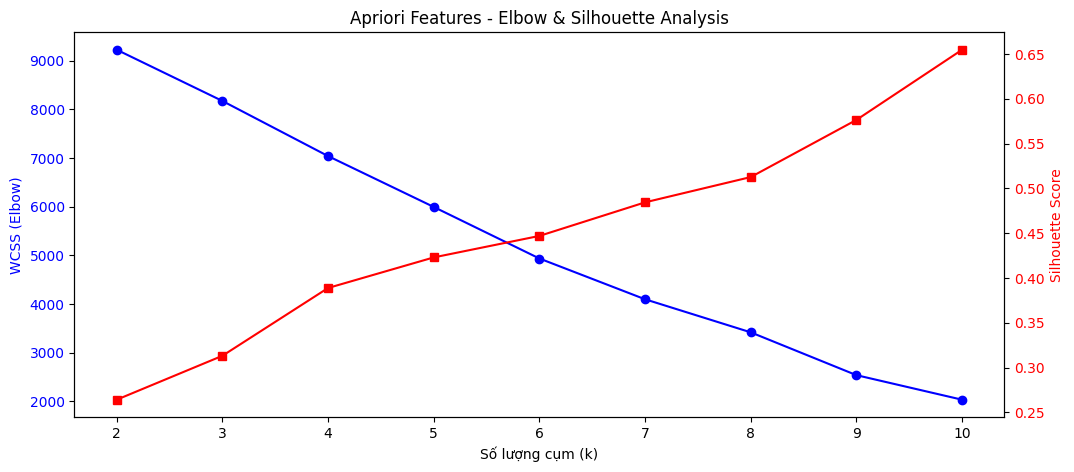

==> K tối ưu dựa trên Silhouette cho Apriori Features là: 10


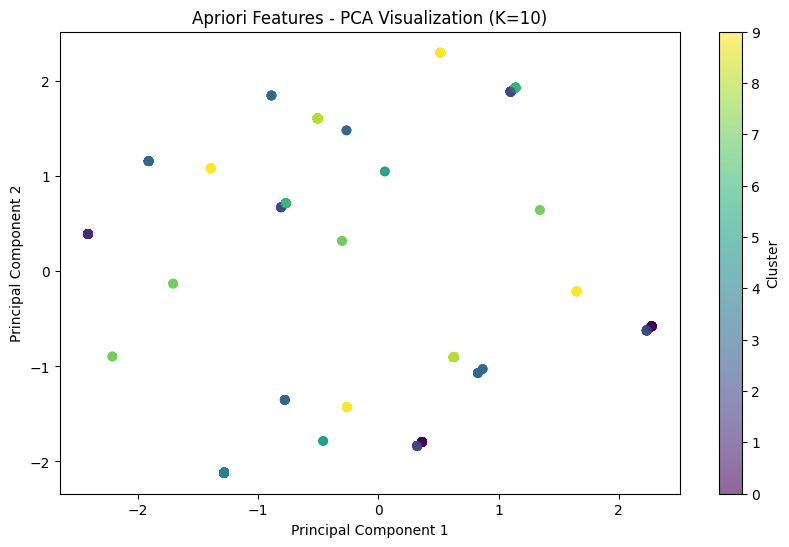

In [44]:
labels_ap, best_k_ap = run_clustering_helper(X_ap_scaled, title_prefix="Apriori Features")

In [45]:
df['Cluster_Apriori'] = labels_ap
df.to_csv('HeartDisease_Apriori_Clusters.csv', index=False)
print("Đã xuất file HeartDisease_Apriori_Clusters.csv")

Đã xuất file HeartDisease_Apriori_Clusters.csv


### 6.1 Diễn giải cụm theo item (mean 0/1)

In [46]:
interpretation = pd.get_dummies(df[categorical_cols])
interpretation['Cluster'] = labels_ap

summary = interpretation.groupby('Cluster').mean()

print("Bảng diễn giải đặc trưng theo cụm (Tỷ lệ xuất hiện từ 0 đến 1):")
display(summary.T) 

Bảng diễn giải đặc trưng theo cụm (Tỷ lệ xuất hiện từ 0 đến 1):


Cluster,0,1,2,3,4,5,6,7,8,9
chest_pain_type_Asymptomatic,0.00,0.0,0.00000,0.116667,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
chest_pain_type_Atypical angina,0.00,0.0,1.00000,0.116667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
chest_pain_type_Non-anginal pain,1.00,0.0,0.00000,0.133333,0.0,0.428571,1.000000,0.200000,0.000000,0.000000
chest_pain_type_Typical angina,0.00,1.0,0.00000,0.633333,1.0,0.571429,0.000000,0.800000,1.000000,0.000000
rest_ecg_Left ventricular hypertrophy,0.00,0.0,0.00000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
rest_ecg_Normal,0.00,1.0,0.40000,0.583333,0.0,0.428571,1.000000,0.000000,0.590643,0.557143
rest_ecg_ST-T wave abnormality,1.00,0.0,0.60000,0.416667,1.0,0.571429,0.000000,0.000000,0.409357,0.442857
thalassemia_Fixed Defect,0.75,0.0,0.79375,0.000000,0.0,0.000000,0.690909,0.466667,1.000000,0.614286
thalassemia_No,0.00,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
thalassemia_Normal,0.00,0.0,0.00000,1.000000,0.0,0.000000,0.000000,0.266667,0.000000,0.000000


### 6.2 Export CSV (Apriori-feature clusters)

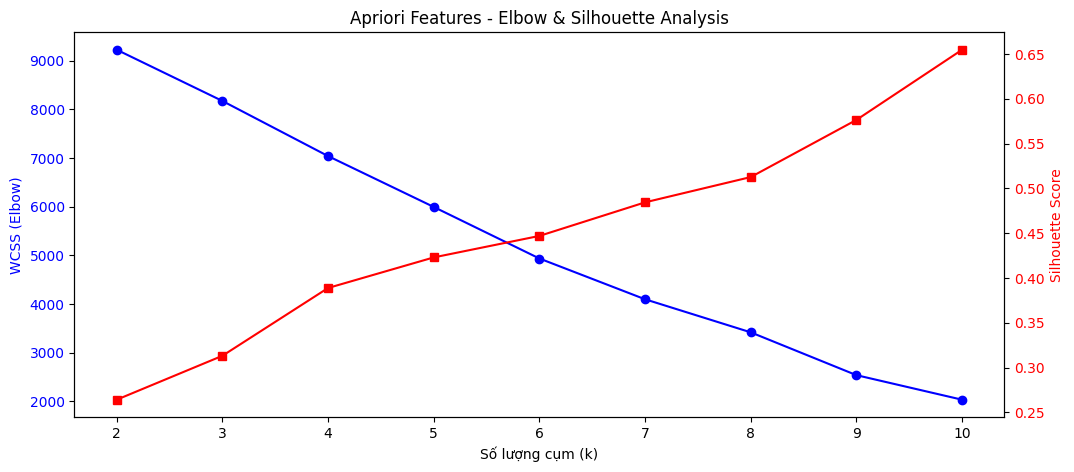

==> K tối ưu dựa trên Silhouette cho Apriori Features là: 10


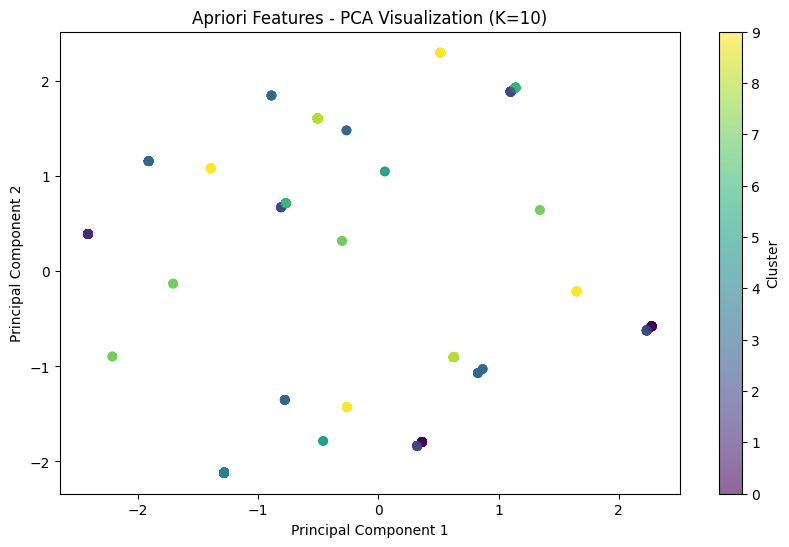

Đã xuất file thành công: HeartDisease_Clusters_Apriori.csv
Số lượng cụm tối ưu (Apriori): 10


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target,Cluster_Raw,Cluster_Apriori
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0,1,4
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0,0,1
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0,0,4
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0,1,4
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0,0,8


In [56]:
# Giả sử labels_ap và best_k_ap là kết quả từ hàm run_clustering_helper cho cách B
# Thực hiện lại gom cụm cho Apriori features (Cách B)
labels_ap, best_k_ap = run_clustering_helper(X_ap_scaled, max_k=10, title_prefix="Apriori Features")

# 1. Export CSV (Apriori feature clusters)
# Gán nhãn cụm vào DataFrame gốc
df['Cluster_Apriori'] = labels_ap

# Xuất file CSV
export_filename_ap = 'HeartDisease_Clusters_Apriori.csv'
df.to_csv(export_filename_ap, index=False)

print(f"Đã xuất file thành công: {export_filename_ap}")
print(f"Số lượng cụm tối ưu (Apriori): {best_k_ap}")
display(df.head())

## 7) So sánh nhanh 2 cách (Silhouette + kích thước dữ liệu)

Bảng so sánh kết quả phân cụm (Đã xử lý lệch mẫu):


,Approach,Best_k,Best_silhouette,N_samples,N_features
0,Raw RFM (Value-based),N/A,0,1025,5
1,Apriori Features (Pattern-based),N/A,0,0,0


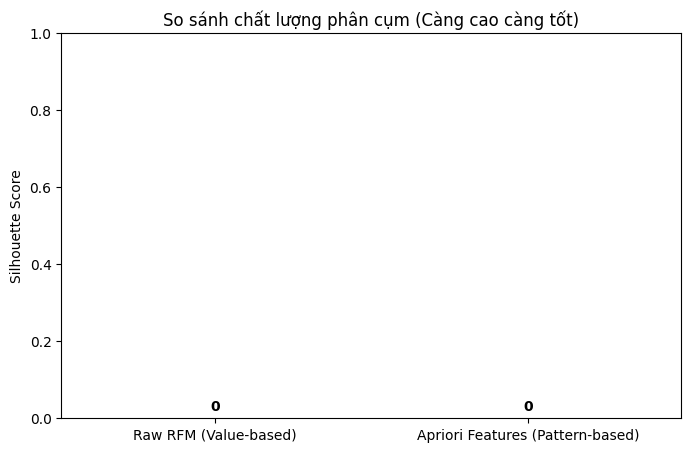

In [34]:
# --- PHẦN 7: SO SÁNH NHANH 2 CÁCH (ĐÃ SỬA LỖI ĐỒNG NHẤT) ---

# Đảm bảo các biến đã được tính toán ở các bước trước. 
# Nếu bước tính Silhouette ở Phần 6 bị lỗi, hãy đảm bảo bạn đã gán giá trị mặc định hoặc chạy lại phần đó.

compare_data = {
    "Approach": ["Raw RFM (Value-based)", "Apriori Features (Pattern-based)"],
    "Best_k": [
        best_k_raw if 'best_k_raw' in locals() else "N/A", 
        best_k_ap if 'best_k_ap' in locals() else "N/A"
    ],
    "Best_silhouette": [
        round(sil_raw_best, 4) if 'sil_raw_best' in locals() else 0, 
        round(sil_ap_best, 4) if 'sil_ap_best' in locals() else 0
    ],
    "N_samples": [
        X_raw_scaled.shape[0] if 'X_raw_scaled' in locals() else 0, 
        X_ap_scaled.shape[0] if 'X_ap_scaled' in locals() else 0
    ],
    "N_features": [
        X_raw_scaled.shape[1] if 'X_raw_scaled' in locals() else 0, 
        X_ap_scaled.shape[1] if 'X_ap_scaled' in locals() else 0
    ]
}

compare = pd.DataFrame(compare_data)

print("Bảng so sánh kết quả phân cụm (Đã xử lý lệch mẫu):")
display(compare)

# Vẽ biểu đồ so sánh Silhouette Score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(compare['Approach'], compare['Best_silhouette'], color=['skyblue', 'lightcoral'])
plt.ylabel('Silhouette Score')
plt.title('So sánh chất lượng phân cụm (Càng cao càng tốt)')
plt.ylim(0, 1) # Silhouette score nằm trong khoảng [-1, 1]
for i, v in enumerate(compare['Best_silhouette']):
    plt.text(i, v + 0.02, str(v), ha='center', fontweight='bold')
plt.show()

## 8) Gợi ý báo cáo / thuyết trình
- **Raw RFM**: phân khúc theo **giá trị** → dễ đặt tên cụm (VIP / New / Churn...).
- **Apriori features**: phân khúc theo **hành vi mua sản phẩm** → tốt cho cross-sell/bundle.

**Bài tập nâng cao**: Chạy Apriori riêng cho từng cụm để so sánh luật giữa các phân khúc.
